*Extra analysis performed utilizing the gtfs-kit library*. In particular, mapping the possible routes of a service. 

gtfs-kit
- [Documentation](https://mrcagney.github.io/gtfs_kit_docs/index.html)
- [Github](https://github.com/mrcagney/gtfs_kit/tree/master)
- [more gtfs links](https://gtfs.org/resources/visualizations/)

# Imports/Installation

In [1]:
import gtfs_kit as gk
import pandas as pd 
import os
import sys
import folium
import numpy as np

In [2]:
# Functions
def collect_shape_ids_for_route(feed, service: str):
    week = feed.get_first_week()
    dates = [week[4], week[5], week[6]]  # First Friday, Saturday & Sunday
    route_timetables = feed.build_route_timetable(service, dates)
    unique_shape_ids = route_timetables.drop_duplicates(subset=['route_id', 'service_id', 'shape_id'])
    # getting all routes in a dictionary
    shape_dict = {x: None for x in sorted(unique_shape_ids['shape_id'].unique())}
    for shape in shape_dict.keys():
        shape_id_example = unique_shape_ids[unique_shape_ids['shape_id']==shape]['trip_id']
        plot = feed.map_trips(trip_ids=shape_id_example, show_stops=True, show_direction=True)
        shape_dict[shape] = plot
    return shape_dict

def display_gk_plot(plot):
    fig = folium.Figure(width=800, height=500)
    fig.add_child(plot)
    return fig

In [3]:
path = "../data/google_transit"

# Using the Library


### Quality Assessment

In [4]:
# removing some rows with null start times
orig_feed = gk.read_feed(path, dist_units='mi')
feed = gk.miscellany.create_shapes(orig_feed, all_trips=True) 
feed.describe()
orig_stops = feed.stops

In [5]:
# removing some rows with null start times
#7 stops are removed, 1 route is removed (I don't see it though...) using feed.clean()
feed = feed.clean()
feed.describe()
clean_stops = feed.stops

In [6]:
# all of these stations do not have a location type...
removed_stops = set(orig_stops.stop_id.unique()).difference(set(clean_stops.stop_id.unique()))
orig_stops[orig_stops['stop_id'].isin(removed_stops)]

,stop_id,stop_name,stop_lat,stop_lon,location_type,parent_station
112,140N,South Ferry Loop,40.701411,-74.013205,NaN,140
113,140S,South Ferry Loop,40.701411,-74.013205,NaN,140
1046,H01S,Aqueduct Racetrack,40.672097,-73.835919,NaN,H01
1087,H19N,Broad Channel,40.609014,-73.816024,NaN,H19
1088,H19S,Broad Channel,40.609014,-73.816024,NaN,H19
1294,N12N,S.B. Coney Island,40.577422,-73.981233,NaN,N12
1295,N12S,S.B. Coney Island,40.577422,-73.981233,NaN,N12


In [7]:
# 214 shape variations!!
feed.trips['shape_id'].nunique()


214

In [8]:
# perfect except for num_stop_time_dists_missing which is because the MTA schedule is precise to only 30 seconds...
gk.miscellany.assess_quality(feed)

,indicator,value
0,num_route_short_names_duplicated,0
1,frac_route_short_names_duplicated,0.0
2,num_stop_time_dists_missing,565060
3,frac_stop_time_dists_missing,1
4,num_direction_ids_missing,0
5,frac_direction_ids_missing,0.0
6,num_trips_missing_shapes,0
7,frac_trips_missing_shapes,0.0
8,num_departure_times_missing,0
9,frac_departure_times_missing,0.0


In [9]:
gk.miscellany.summarize(feed).head()

,table,column,num_values,num_nonnull_values,num_unique_values,min_value,max_value
0,agency,agency_id,1,1,1,MTA_NYCT,MTA_NYCT
1,agency,agency_name,1,1,1,MTA New York City Transit,MTA New York City Transit
2,agency,agency_url,1,1,1,http://www.mta.info,http://www.mta.info
3,agency,agency_timezone,1,1,1,America/New_York,America/New_York
4,agency,agency_lang,1,1,1,en,en


In [10]:
week = feed.get_first_week()
# Getting 3 days so that we see the stats for each schedule type
dates = [week[4], week[5], week[6]]  # First Friday, Saturday & Sunday

In [11]:
trip_stats = feed.compute_trip_stats()
trip_stats.head().T

,4,312,684,6,314
trip_id,AFA24GEN-1038-Sunday-00_007200_1..N03R,AFA24GEN-1039-Saturday-00_007200_1..N03R,AFA24GEN-1093-Weekday-00_007450_1..N03R,AFA24GEN-1038-Sunday-00_009200_1..N03R,AFA24GEN-1039-Saturday-00_009200_1..N03R
route_id,1,1,1,1,1
route_short_name,1,1,1,1,1
route_type,1,1,1,1,1
direction_id,0,0,0,0,0
shape_id,shape_006,shape_006,shape_006,shape_006,shape_006
stop_pattern_name,0-1,0-1,0-1,0-1,0-1
num_stops,38,38,38,38,38
start_time,01:12:00,01:12:00,01:14:30,01:32:00,01:32:00
end_time,02:10:30,02:10:30,02:12:30,02:30:30,02:30:30


In [12]:
fts = feed.compute_feed_time_series((trip_stats), dates, freq='1h')
fts

indicator,num_trip_ends,num_trip_starts,num_trips,service_distance,service_duration,service_speed
datetime,,,,,,
2024-12-20 00:00:00,46.0,146.0,174.0,2345.111737,153.350000,15.292545
2024-12-20 01:00:00,122.0,133.0,232.0,1874.401445,123.916667,15.126306
2024-12-20 02:00:00,131.0,130.0,240.0,1738.811389,115.566667,15.045960
2024-12-20 03:00:00,130.0,130.0,239.0,1737.564614,115.433333,15.052538
2024-12-20 04:00:00,129.0,141.0,250.0,1803.564311,118.666667,15.198576
...,...,...,...,...,...,...
2024-12-22 19:00:00,298.0,281.0,535.0,4038.115333,249.183333,16.205399
2024-12-22 20:00:00,274.0,262.0,500.0,3849.135503,236.200000,16.296086
2024-12-22 21:00:00,258.0,243.0,471.0,3687.062012,225.083333,16.380875


## Plots of Service by Day Type

<Axes: xlabel='datetime'>

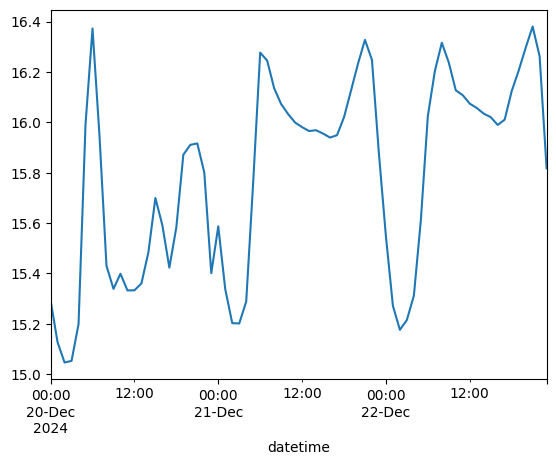

In [13]:
fts['service_speed'].plot()

<Axes: xlabel='datetime'>

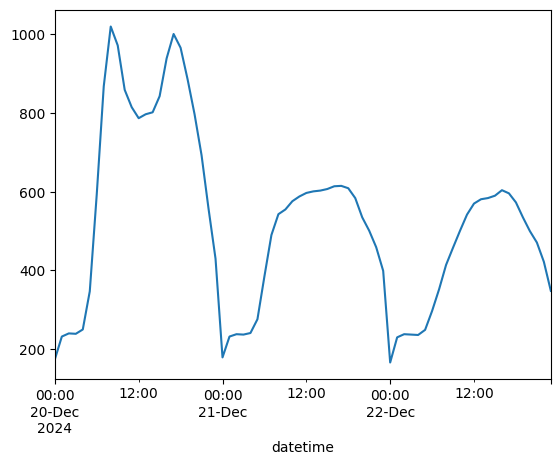

In [14]:
fts['num_trips'].plot()

## Route Timetables

In [18]:
# possible routes feed.routes['route_id'].unique()
route_id = 'L'
route_timetables_L = feed.build_route_timetable(route_id, dates)
route_timetables_L.head()

,route_id,trip_id,service_id,trip_headsign,direction_id,shape_id,stop_id,arrival_time,departure_time,stop_sequence,date
407695,L,BFA24GEN-L049-Weekday-00_000650_L..N01R,Weekday,8 Av,0,shape_173,L29N,00:06:30,00:06:30,1,20241220
407696,L,BFA24GEN-L049-Weekday-00_000650_L..N01R,Weekday,8 Av,0,shape_173,L28N,00:08:00,00:08:00,2,20241220
407697,L,BFA24GEN-L049-Weekday-00_000650_L..N01R,Weekday,8 Av,0,shape_173,L27N,00:10:00,00:10:00,3,20241220
407698,L,BFA24GEN-L049-Weekday-00_000650_L..N01R,Weekday,8 Av,0,shape_173,L26N,00:11:30,00:11:30,4,20241220
407699,L,BFA24GEN-L049-Weekday-00_000650_L..N01R,Weekday,8 Av,0,shape_173,L25N,00:13:00,00:13:00,5,20241220


In [26]:
# getting one trip_id per shape_id
unique_shape_ids = route_timetables_L.drop_duplicates(subset=['route_id', 'service_id', 'shape_id'])
# Getting all Shape IDs in one file 
print(f"There are {route_timetables_L['shape_id'].nunique()} unique routes for the {route_id}")
unique_shape_ids

There are 5 unique routes for the L


,route_id,trip_id,service_id,trip_headsign,direction_id,shape_id,stop_id,arrival_time,departure_time,stop_sequence,date
407695,L,BFA24GEN-L049-Weekday-00_000650_L..N01R,Weekday,8 Av,0,shape_173,L29N,00:06:30,00:06:30,1,20241220
407791,L,BFA24GEN-L049-Weekday-00_005400_L..S01R,Weekday,Canarsie-Rockaway Pkwy,1,shape_170,L01S,00:54:00,00:54:00,1,20241220
408487,L,BFA24GEN-L049-Weekday-00_031950_L..N02R,Weekday,8 Av,0,shape_172,L28N,05:19:30,05:19:30,1,20241220
409581,L,BFA24GEN-L049-Weekday-00_045300_L..S05R,Weekday,Myrtle-Wyckoff Avs,1,shape_169,L01S,07:33:00,07:33:00,1,20241220
410003,L,BFA24GEN-L049-Weekday-00_048750_L..N05R,Weekday,8 Av,0,shape_171,L17N,08:07:30,08:07:30,1,20241220
385056,L,BFA24GEN-L026-Saturday-00_000650_L..N01R,Saturday,8 Av,0,shape_173,L29N,00:06:30,00:06:30,1,20241221
385152,L,BFA24GEN-L026-Saturday-00_005400_L..S01R,Saturday,Canarsie-Rockaway Pkwy,1,shape_170,L01S,00:54:00,00:54:00,1,20241221
386472,L,BFA24GEN-L026-Saturday-00_044400_L..N02R,Saturday,8 Av,0,shape_172,L28N,07:24:00,07:24:00,1,20241221
396998,L,BFA24GEN-L026-Sunday-00_000650_L..N01R,Sunday,8 Av,0,shape_173,L29N,00:06:30,00:06:30,1,20241222
397094,L,BFA24GEN-L026-Sunday-00_005400_L..S01R,Sunday,Canarsie-Rockaway Pkwy,1,shape_170,L01S,00:54:00,00:54:00,1,20241222


## Trip Stats

In [27]:
friday = dates = [week[4]]
trip_information_fri = feed.compute_route_stats(trip_stats, friday)
# I don't trust the peak information
trip_information_fri = trip_information_fri.drop(columns=['route_short_name', 'date', 'peak_num_trips', 'is_bidirectional'
                                                          ,'route_type', 'is_loop', 'peak_start_time', 'peak_end_time', 'min_headway'])
trip_information_fri.head(10)

,route_id,num_trips,num_trip_starts,num_trip_ends,num_stop_patterns,start_time,end_time,max_headway,mean_headway,service_distance,service_duration,service_speed,mean_trip_distance,mean_trip_duration
0,1,462,462,446,6,00:06:30,25:57:00,9.0,4.787625,6634.179454,433.616667,15.299641,14.359696,0.938564
1,2,324,324,301,7,00:19:00,27:40:30,13.0,7.114428,7929.155259,541.225000,14.650386,24.472701,1.670448
2,3,304,304,300,5,00:02:30,24:48:00,12.5,7.389175,4750.100715,314.541667,15.101658,15.625331,1.034677
3,4,370,370,351,21,00:05:30,27:06:00,11.5,6.132479,7362.866867,445.025000,16.544839,19.899640,1.202770
4,5,329,329,328,29,00:02:00,24:16:00,14.0,6.548387,6337.060243,391.058333,16.204898,19.261581,1.188627
5,6,439,439,419,6,00:07:00,26:06:00,10.5,4.977352,5854.240445,417.166667,14.033337,13.335400,0.950266
6,6X,113,113,113,2,06:09:00,21:15:00,10.5,7.273684,1582.043788,111.416667,14.199346,14.000388,0.985988
7,7,535,535,520,5,00:11:30,25:23:30,10.0,4.213864,5206.509145,341.866667,15.229648,9.731793,0.639003
8,7X,107,107,107,2,06:15:00,22:15:30,10.0,5.732877,1052.467343,65.875000,15.976734,9.836143,0.615654
9,A,375,375,351,22,00:11:30,27:49:00,16.0,6.609302,9342.548238,521.166667,17.926220,24.913462,1.389778


In [28]:
# to get the headway for this I'll need to include avg trip duration for each route 
gk.routes.compute_route_time_series_0(trip_stats, friday[0], split_directions=False, freq='60Min')['num_trips'].head()

route_id,1,2,3,4,5,6,6X,7,7X,A,...,H,J,L,M,N,Q,R,SI,W,Z
datetime,,,,,,,,,,,,,,,,,,,,,
2024-12-20 00:00:00,25,35,17,32,18,27,0,25,0,44,...,16,18,27,21,28,21,18,12,0,0
2024-12-20 01:00:00,44,37,24,42,18,46,0,36,0,58,...,21,36,39,18,33,36,27,18,0,0
2024-12-20 02:00:00,37,52,24,48,18,38,0,27,0,69,...,18,36,30,18,42,36,27,18,0,0
2024-12-20 03:00:00,36,52,24,48,18,37,0,27,0,69,...,18,36,30,18,42,36,27,18,0,0
2024-12-20 04:00:00,37,53,24,50,19,38,0,30,0,70,...,18,36,31,18,42,37,27,18,0,0


In [23]:
## this ignores trips that end after 24:00
# trip_information_fri.sort_values(by='num_trip_ends')
trip_information_fri.sort_values(by='service_speed').head()

,route_id,num_trips,num_trip_starts,num_trip_ends,num_stop_patterns,start_time,end_time,max_headway,min_headway,mean_headway,service_distance,service_duration,service_speed,mean_trip_distance,mean_trip_duration
15,FS,238,238,238,2,00:00:00,23:56:30,10,10,10,322,27,12,1,0
27,W,187,187,187,4,06:13:00,22:55:30,18,2,10,"1,805",138,13,10,1
25,R,303,303,297,9,00:15:00,25:17:00,12,2,7,"5,676",410,14,19,1
5,6,439,439,419,6,00:07:00,26:06:00,10,0,5,"5,854",417,14,13,1
6,6X,113,113,113,2,06:09:00,21:15:00,10,3,7,"1,582",111,14,14,1


## Stop Patterns

In [24]:
trip_information_fri[['route_id', 'num_stop_patterns']].head()


,route_id,num_stop_patterns
0,1,6
1,2,7
2,3,5
3,4,21
4,5,29


In [25]:
# the Z has 6 trips with different stopping patterns
# I think the stop patterns are for number of variations of each direction shape
## e.g.: 0-1 is the most popular stop pattern going south, 0-2 is 2nd most popular, etc...
trip_stats[(trip_stats['route_id']=='F')].groupby('stop_pattern_name')['duration'].count()

stop_pattern_name
0-1    256
0-2     96
0-3     32
0-4     11
0-5      7
0-6      1
1-1    299
1-2     65
1-3     38
1-4      1
Name: duration, dtype: int64

## Mean duration by shape ID

In [29]:
duration_by_shape = trip_stats.groupby(['route_id', 'stop_pattern_name', 'shape_id']).mean('duration')
duration_by_shape_no_S = duration_by_shape.reset_index()[~duration_by_shape.reset_index().route_id.isin(['FS', 'GS', 'H'])]

In [30]:
# A has the longest service (barely beating the 2)
# Ironically the A shuttle (lefferts branch late night) is the shortest non-shuttle
# duration_by_shape.sort_values(by='duration')
duration_by_shape_no_S.sort_values(by='duration')


,route_id,stop_pattern_name,shape_id,route_type,direction_id,num_stops,is_loop,duration,distance,speed
100,A,1-4,shape_098,1.0,1.0,8.0,0.0,0.181921,2.572688,14.146105
88,A,0-4,shape_100,1.0,0.0,8.0,0.0,0.182051,2.572688,14.140791
61,5,1-2,shape_062,1.0,1.0,6.0,0.0,0.183333,3.909813,21.326253
47,5,0-2,shape_014,1.0,0.0,6.0,0.0,0.199706,3.909813,19.581921
172,M,1-3,shape_177,1.0,1.0,8.0,0.0,0.210759,2.721544,12.931973
...,...,...,...,...,...,...,...,...,...,...
8,2,0-3,shape_037,1.0,0.0,52.0,0.0,1.766667,25.640054,14.528407
10,2,1-2,shape_007,1.0,1.0,61.0,0.0,1.770912,24.480237,13.848050
87,A,0-3,shape_163,1.0,0.0,59.0,0.0,1.786538,31.088137,17.401853
11,2,1-3,shape_009,1.0,1.0,52.0,0.0,1.795000,25.640054,14.294815


In [33]:
# the 2 has the most stops (61)
duration_by_shape.sort_values(by='num_stops')
duration_by_shape_no_S.sort_values(by='num_stops')[0:15]

,route_id,stop_pattern_name,shape_id,route_type,direction_id,num_stops,is_loop,duration,distance,speed
61,5,1-2,shape_062,1,1,6,0,0,4,21
47,5,0-2,shape_014,1,0,6,0,0,4,20
100,A,1-4,shape_098,1,1,8,0,0,3,14
88,A,0-4,shape_100,1,0,8,0,0,3,14
169,M,0-3,shape_174,1,0,8,0,0,3,13
199,R,1-3,shape_201,1,1,8,0,0,3,14
172,M,1-3,shape_177,1,1,8,0,0,3,13
14,3,0-2,shape_003,1,0,9,0,0,6,16
16,3,1-2,shape_041,1,1,9,0,0,6,16
206,SI,1-2,shape_211,2,1,10,0,1,14,25


### Mapping one of the routes

In [35]:
shape_ids_R = collect_shape_ids_for_route(feed, 'R')
print(shape_ids_R.keys())
plot = display_gk_plot(shape_ids_R['shape_199'])
plot

dict_keys(['shape_199', 'shape_202', 'shape_156', 'shape_205', 'shape_201', 'shape_203', 'shape_155', 'shape_200', 'shape_204'])


In [114]:
# 6 trains all go to either 3rd ave-e 180th st, parkchester or Pelham Bay Park
shape_ids_6 = collect_shape_ids_for_route(feed, '6')
print(shape_ids_6.keys())
plot = display_gk_plot(shape_ids_6['shape_069'])
plot

dict_keys(['shape_069', 'shape_071', 'shape_072', 'shape_073', 'shape_075', 'shape_076'])


In [ ]:
# 6X trains all go from 3rd ave-e 180th st to hunts pt ave, to parkchester and then local 
shape_ids_6X = collect_shape_ids_for_route(feed, '6X')
print(shape_ids_6X.keys())
plot = display_gk_plot(shape_ids_6X['shape_074'])
plot

dict_keys(['shape_070', 'shape_074'])
